In [4]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import json

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Input, Conv1D, Flatten, Dropout, Concatenate
import array

In [6]:
samples = []

with open('./sample_materialized.txt', encoding='utf8') as f:
    for line in f:
        samples.append(json.loads(line.strip()))

In [7]:
def onehot(idx, l=3):
    result = [0] * 3
    result[idx] = 1
    return result

def sample2vec(text, phone, l=64):
    x = [i for i in text.encode('cp1251')]
    x = x + [0] * (l - len(x))
    idx = text.index(phone)
    if idx < 0:
        raise ValueError
    y = ([0] * idx) + ([2]) + ([1] * (len(phone) - 1)) + ([0] * (l - idx - len(phone)))
    return (x, [onehot(i, l=3) for i in y])

In [8]:
def json2vec(sample, l=64, start=None):
    text = sample['message']
    
    chars = [i for i in text.encode('cp1251')]
    y = np.zeros(len(chars))
    for idx in sample['phone_indexes']:
        y[idx[0]:idx[1]] = 1
    
    if start == None:
        start = np.random.randint(0, len(text) - 1)
    end = start + l
    
    x = chars[start:end]
    y = y[start:end]
    
    padding = l - len(x)
    if padding > 0:
        x = x + ([0] * padding)
        y = np.pad(y, [(0, padding)], mode='constant')
    
    return (x, y)

(x, y) = json2vec(samples[1])

In [9]:
X = []
Y = []
for sample in samples:
    for i in range(10):
        (x, y) = json2vec(sample)
        X.append(x)
        Y.append(y)
        
print(len(X))

26590


In [92]:
inputs = Input(shape=(64,), name="input")

emb = x = Embedding(256, 4, input_length=64, name="embedding")(inputs)

x = Conv1D(32, 13, padding='same', activation='relu', name="conv1d-1")(x)
x = Dropout(0.1, name="dropout-1")(x)
aux = Concatenate(name="aux")([x, emb])
x = Conv1D(64, 13, padding='same', activation='relu', name="conv1d-2")(aux)
x = Dropout(0.1, name="dropout-2")(x)

x = Dense(1, activation='sigmoid', name="final-dense")(x)
predictions = Flatten()(x)

model = Model(inputs = inputs, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

In [93]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 64, 4)        1024        input[0][0]                      
__________________________________________________________________________________________________
conv1d-1 (Conv1D)               (None, 64, 32)       1696        embedding[0][0]                  
__________________________________________________________________________________________________
dropout-1 (Dropout)             (None, 64, 32)       0           conv1d-1[0][0]                   
__________________________________________________________________________________________________
aux (Conca

In [96]:
model.fit(np.array(X), np.array(Y), epochs=10, batch_size=64, validation_split=0.05,
          shuffle=True)

Train on 25260 samples, validate on 1330 samples
Epoch 1/10
25260/25260 [==============================] - 2s 86us/step - loss: 9.1146e-04 - binary_accuracy: 0.9997 - val_loss: 0.0031 - val_binary_accuracy: 0.9990
Epoch 2/10
25260/25260 [==============================] - 2s 86us/step - loss: 7.8333e-04 - binary_accuracy: 0.9997 - val_loss: 0.0041 - val_binary_accuracy: 0.9989
Epoch 3/10
25260/25260 [==============================] - 2s 86us/step - loss: 8.8155e-04 - binary_accuracy: 0.9997 - val_loss: 0.0043 - val_binary_accuracy: 0.9985
Epoch 4/10
25260/25260 [==============================] - 2s 86us/step - loss: 7.4898e-04 - binary_accuracy: 0.9997 - val_loss: 0.0036 - val_binary_accuracy: 0.9990
Epoch 5/10
25260/25260 [==============================] - 2s 86us/step - loss: 6.8119e-04 - binary_accuracy: 0.9998 - val_loss: 0.0035 - val_binary_accuracy: 0.9991
Epoch 6/10
25260/25260 [==============================] - 2s 86us/step - loss: 6.5599e-04 - binary_accuracy: 0.9998 - val_loss

In [14]:
model.save_weights("model.h5")

## Визуализация полученных embedding'ов

In [19]:
model.load_weights("model.h5")

In [20]:
weights = model.get_weights()[0]

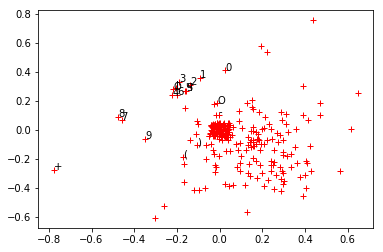

In [22]:
import matplotlib.pyplot as plt

for i in ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '(', ')', '-', '+',
          'l', 'Ч', 'O', 'О']:
    code = ord(i.encode('cp1251'))
    center = weights[code]
    plt.annotate(i, center)

#for i in range(250):
#    try:
#        c = array.array('B', [i]).tobytes().decode('cp1251')
#        code = i

#        center = weights[code]
#        plt.annotate(c, center)
#    except UnicodeDecodeError:
#        pass

plt.plot(weights[:, 0], weights[:, 1], 'r+')

In [23]:
from IPython.core.display import HTML

def mask_text(text, mask):
    result = ""
    text = array.array('B', text).tobytes().decode("cp1251")
    for i in range(len(text)):
        if mask[i] > 0:
            result += "<b>" + text[i] + "</b>"
        else:
            result += text[i]
            
    return "<code>" + result + "</code>"

def vec2text(text):
    return "".join([chr(i) for i in text])

In [41]:
s = samples[41]
s = {'phone_indexes': [], 'message': " фото на ВОТСАП на номер 8(9OЧ)7738//////-О6l"}
print(s)

(x, y) = json2vec(s, start=0)
prediction = model.predict(np.array([x]))[0]
mask = np.round(prediction)
mask
HTML(mask_text(x, mask))

{'phone_indexes': [], 'message': ' фото на ВОТСАП на номер 8(9OЧ)7738//////-О6l'}


In [43]:
model.fit?

In [4]:
def foo():
    for i in [1,2,3,4]:
        yield i
        
def p(x):
    for i in x:
        yield i**2
        
for i in p(foo()):
    print(i)

1
4
9
16
